## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time_reduced.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of         depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0           1    -10.049883     493.493435   -62.756461    -104.669918   
1           2    -10.049883     493.493435   -62.756461    -104.669918   
2           3    -10.049883     493.493435   -62.756461    -104.669918   
3           4    -10.049883     493.493435   -62.756461    -104.669918   
4           5    -10.049883     493.493435   -62.756461    -104.669918   
...       ...           ...            ...          ...            ...   
751195     46    -12.920028     494.226632   -46.982710     -95.220702   
751196     47    -12.920028     494.226632   -46.982710     -95.220702   
751197     48    -12.920028     494.226632   -46.982710     -95.220702   
751198     49    -12.920028     494.226632   -46.982710     -95.220702   
751199     50    -12.920028     494.226632   -46.982710     -95.220702   

        Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0                

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 15024
Number of training points: 450700


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(450700, 45)
(300500, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.022038039
RMSE of after m1 0.020646904
RMSE of after m3 0.06673724
RMSE of after m4 0.06723575
RMSE of after m0 0.019286959
RMSE of after m1 0.017695302
RMSE of after m3 0.010491186
RMSE of after m4 0.011179104
RMSE of after m0 0.018380165
RMSE of after m1 0.015138375
RMSE of after m3 0.00986036
RMSE of after m4 0.010240184
RMSE of after m0 0.018203165
RMSE of after m1 0.015612987
RMSE of after m3 0.024901621
RMSE of after m4 0.025003677
RMSE of after m0 0.021179052
RMSE of after m1 0.017835665
RMSE of after m3 0.024310147
RMSE of after m4 0.024875913
RMSE of after m0 0.022767883
RMSE of after m1 0.01687486
RMSE of after m3 0.02892738
RMSE of after m4 0.028489863
RMSE of after m0 0.027406536
RMSE of after m1 0.020747524
RMSE of after m3 0.0120855775
RMSE of after m4 0.012646416
RMSE of after m0 0.023189807
RMSE of after m1 0.01897462
RMSE of after m3 0.009519326
RMSE of after m4 0.00982378
RMSE of after m0 0.022694618
RMSE of after m1 0.018108986
RMSE of after m3 0.0

RMSE of after m1 0.021651348
RMSE of after m3 0.061478656
RMSE of after m4 0.07521974
RMSE of after m0 0.010552374
RMSE of after m1 0.021496372
RMSE of after m3 0.011091106
RMSE of after m4 0.026966164
RMSE of after m0 0.012610018
RMSE of after m1 0.019412216
RMSE of after m3 0.043385174
RMSE of after m4 0.04017357
RMSE of after m0 0.011203406
RMSE of after m1 0.018229812
RMSE of after m3 0.059234254
RMSE of after m4 0.060820185
RMSE of after m0 0.013222861
RMSE of after m1 0.019171946
RMSE of after m3 0.079221025
RMSE of after m4 0.087491564
RMSE of after m0 0.008953358
RMSE of after m1 0.015654095
RMSE of after m3 0.04113354
RMSE of after m4 0.03404986
RMSE of after m0 0.007916798
RMSE of after m1 0.013557124
RMSE of after m3 0.072044075
RMSE of after m4 0.050290838
RMSE of after m0 0.0076563885
RMSE of after m1 0.009077931
RMSE of after m3 0.041779313
RMSE of after m4 0.04018555
RMSE of after m0 0.007467545
RMSE of after m1 0.008619295
RMSE of after m3 0.03155385
RMSE of after m4 0.

RMSE of after m1 0.024916865
RMSE of after m3 0.01591355
RMSE of after m4 0.014717769
RMSE of after m0 0.025420392
RMSE of after m1 0.027712416
RMSE of after m3 0.02534771
RMSE of after m4 0.02334046
RMSE of after m0 0.026220338
RMSE of after m1 0.026502125
RMSE of after m3 0.018138736
RMSE of after m4 0.017470967
RMSE of after m0 0.025035717
RMSE of after m1 0.026179567
RMSE of after m3 0.017716365
RMSE of after m4 0.017019646
RMSE of after m0 0.022781784
RMSE of after m1 0.025609607
RMSE of after m3 0.017212627
RMSE of after m4 0.01587252
RMSE of after m0 0.021680774
RMSE of after m1 0.024616882
RMSE of after m3 0.01879747
RMSE of after m4 0.018444572
RMSE of after m0 0.022679323
RMSE of after m1 0.025006738
RMSE of after m3 0.014972391
RMSE of after m4 0.014201978
RMSE of after m0 0.02129834
RMSE of after m1 0.029686466
RMSE of after m3 0.022442646
RMSE of after m4 0.021865357
RMSE of after m0 0.021356786
RMSE of after m1 0.026365958
RMSE of after m3 0.013968327
RMSE of after m4 0.0

RMSE of after m3 0.040185824
RMSE of after m4 0.0360577
RMSE of after m0 0.010507981
RMSE of after m1 0.010569971
RMSE of after m3 0.10194697
RMSE of after m4 0.0907514
RMSE of after m0 0.013175692
RMSE of after m1 0.013543387
RMSE of after m3 0.106709145
RMSE of after m4 0.099696346
RMSE of after m0 0.020378625
RMSE of after m1 0.021302156
RMSE of after m3 0.019847816
RMSE of after m4 0.018889897
RMSE of after m0 0.01864292
RMSE of after m1 0.024298294
RMSE of after m3 0.023965923
RMSE of after m4 0.022917459
RMSE of after m0 0.017794888
RMSE of after m1 0.019377543
RMSE of after m3 0.02266831
RMSE of after m4 0.022096116
RMSE of after m0 0.016325517
RMSE of after m1 0.016507184
RMSE of after m3 0.026512552
RMSE of after m4 0.026170788
RMSE of after m0 0.016537508
RMSE of after m1 0.018913116
RMSE of after m3 0.013768123
RMSE of after m4 0.012822481
RMSE of after m0 0.020727959
RMSE of after m1 0.021369899
RMSE of after m3 0.017079689
RMSE of after m4 0.015829062
RMSE of after m0 0.01

RMSE of after m1 0.014115235
RMSE of after m3 0.05162787
RMSE of after m4 0.0500044
RMSE of after m0 0.008671597
RMSE of after m1 0.0145929335
RMSE of after m3 0.036220934
RMSE of after m4 0.033097263
RMSE of after m0 0.010213207
RMSE of after m1 0.01677891
RMSE of after m3 0.015170372
RMSE of after m4 0.01952844
RMSE of after m0 0.008042909
RMSE of after m1 0.014716207
RMSE of after m3 0.026828784
RMSE of after m4 0.02307504
RMSE of after m0 0.008504044
RMSE of after m1 0.013652119
RMSE of after m3 0.010702765
RMSE of after m4 0.012234305
RMSE of after m0 0.010178512
RMSE of after m1 0.0174028
RMSE of after m3 0.035139844
RMSE of after m4 0.04668017
RMSE of after m0 0.011282071
RMSE of after m1 0.017184637
RMSE of after m3 0.02513953
RMSE of after m4 0.030527698
RMSE of after m0 0.009922673
RMSE of after m1 0.016372848
RMSE of after m3 0.017903358
RMSE of after m4 0.020588676
RMSE of after m0 0.009821959
RMSE of after m1 0.01677327
RMSE of after m3 0.019294126
RMSE of after m4 0.02056

RMSE of after m4 0.010669891
RMSE of after m0 0.028291615
RMSE of after m1 0.024350211
RMSE of after m3 0.014416807
RMSE of after m4 0.011858463
RMSE of after m0 0.030225117
RMSE of after m1 0.025275586
RMSE of after m3 0.023062816
RMSE of after m4 0.02228302
RMSE of after m0 0.025680637
RMSE of after m1 0.02347309
RMSE of after m3 0.020283328
RMSE of after m4 0.018633304
RMSE of after m0 0.031634703
RMSE of after m1 0.02464272
RMSE of after m3 0.018516252
RMSE of after m4 0.017814297
RMSE of after m0 0.029615497
RMSE of after m1 0.024535647
RMSE of after m3 0.01749643
RMSE of after m4 0.016073257
RMSE of after m0 0.03158925
RMSE of after m1 0.023963751
RMSE of after m3 0.017851375
RMSE of after m4 0.016116409
RMSE of after m0 0.032870576
RMSE of after m1 0.0251275
RMSE of after m3 0.018754281
RMSE of after m4 0.016996365
RMSE of after m0 0.028686836
RMSE of after m1 0.023446603
RMSE of after m3 0.024760572
RMSE of after m4 0.023557
RMSE of after m0 0.030515138
RMSE of after m1 0.02330

In [28]:
print(train_data.shape)
print(test_data.shape)
print(train_y_pred.shape)
print(train_y_true.shape)
print(train_time.shape)

print(train_time[0])
print(train_time[50*24])
print(train_time[50*24*2])

(450700, 45)
(300500, 45)
torch.Size([450700, 1])
torch.Size([450700, 1])
(450700,)
2012-01-03 00:00:00
2012-01-05 00:00:00
2012-01-10 00:00:00


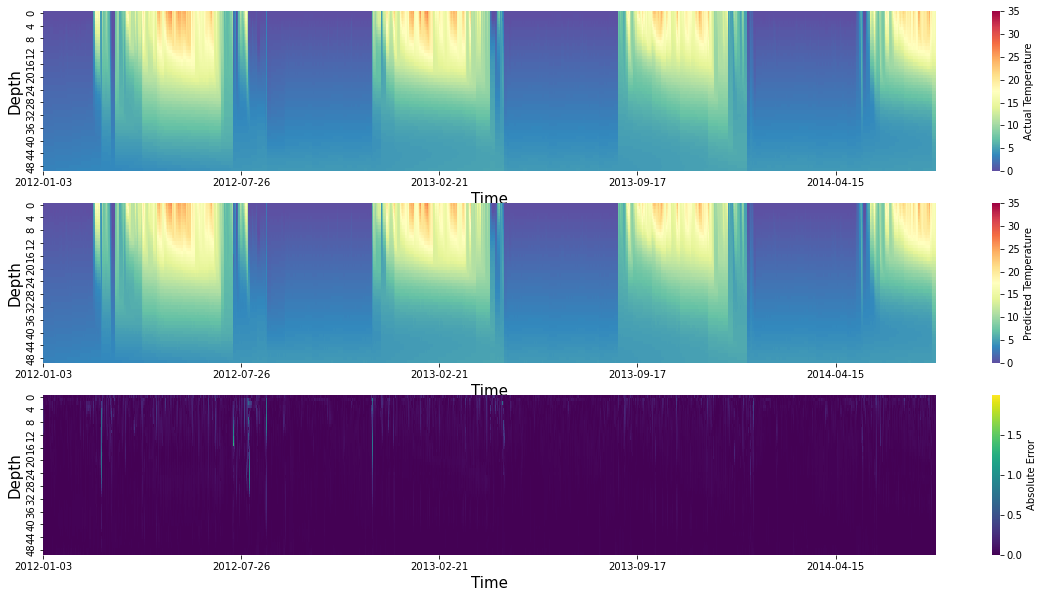

In [24]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [ ]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [ ]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Finetuning

In [ ]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [ ]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [ ]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [ ]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out3 = torch.tensor(train_mean[m3_output_column_ix[0]]).float().to(device)
std_out3 = torch.tensor(train_std[m3_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m4_pred = ice_model(m4_input)
        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)

        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out3)/std_out3
        
        loss_m3 = criterion(m3_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m3
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [ ]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [ ]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Compute Model Similarity after Finetuning

In [ ]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [ ]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
# Freeze all models again and compute finetuned diffusivity values

In [ ]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [ ]:
PATH = f"./saved_models/diffusion_model_finetuned_reduced.pth"
torch.save(heat_diff_model.state_dict(), PATH)

In [ ]:
def plot_output_freeLimits(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r')
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r')
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

In [ ]:
plot_output_freeLimits(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output_freeLimits(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))